In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

time_epoch = 60
total_epochs = 7

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=120000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df_all = df_all[df_all['time'] <= time_epoch * total_epochs]
df_all.index = df_all['time']
df_all.drop(columns=['time'],inplace=True)

In [2]:
# get all the host in the buckets we are interested in 

hosts = np.array(list(set(df_all['source computer'].values))) 

print('Testing a total of', len(hosts), 'hosts')

Testing a total of 1269 hosts


In [3]:
from helper import group_scale_data, group_scale_data_batch

groupped_data, hosts, parameters = group_scale_data(df_all, size_of_bin_seconds=time_epoch,
                                                    doScale=True, addZeros=True, scaler='log', hosts=hosts, verbose=1)

A total of 7 time epochs have been encountered
Done with 0 hosts out of 1269
Done with 63 hosts out of 1269
Done with 126 hosts out of 1269
Done with 189 hosts out of 1269
Done with 252 hosts out of 1269
Done with 315 hosts out of 1269
Done with 378 hosts out of 1269
Done with 441 hosts out of 1269
Done with 504 hosts out of 1269
Done with 567 hosts out of 1269
Done with 630 hosts out of 1269
Done with 693 hosts out of 1269
Done with 756 hosts out of 1269
Done with 819 hosts out of 1269
Done with 882 hosts out of 1269
Done with 945 hosts out of 1269
Done with 1008 hosts out of 1269
Done with 1071 hosts out of 1269
Done with 1134 hosts out of 1269
Done with 1197 hosts out of 1269
Done with 1260 hosts out of 1269
Scaeling...


In [4]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus

In [5]:
number_of_mixtures = range(5,16)
update_powers = np.arange(0.1, 1.1, 0.1)

likelihoods = []

for mixtures in number_of_mixtures:

    kplusplus = KPlusPlus(mixtures, groupped_data.values[:, :2], stochastic=True, stochastic_n_samples=3000)
    
    # random initialization
    kplusplus.init_centers()

    for update_power in update_powers:
        onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, 500, n_clusters=8, update_power=update_power)
        # ignore epoch index for now

        data = groupped_data.values[:,[0,1,3]]

        np.random.shuffle(data)


        onlineEM.fit(data)

        likelihood = onlineEM.calculate_likelihood(data[:,:2])
        likelihoods.append(likelihood)
        
        print('For number of mixtures', mixtures, 'and update_power', update_power, 'log likelihood is', likelihood)

For number of mixtures 5 and update_power 0.1 log likelihood is -38140.08070152306
For number of mixtures 5 and update_power 0.2 log likelihood is -38118.26265193213
For number of mixtures 5 and update_power 0.3 log likelihood is -38135.45953775837
For number of mixtures 5 and update_power 0.4 log likelihood is -38450.484774054166
For number of mixtures 5 and update_power 0.5 log likelihood is -38220.49427546304


KeyboardInterrupt: 

In [19]:
import numpy as np
np.set_printoptions(threshold=np.inf)

likelihoods = np.reshape(np.array(likelihoods), (len(number_of_mixtures), len(update_powers)))

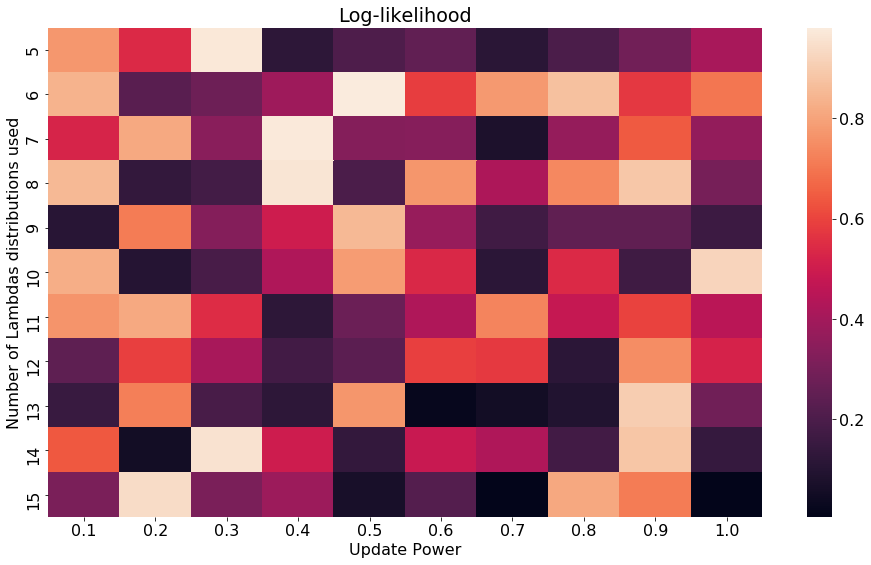

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
rcParams['font.size'] = 16

ax = sns.heatmap(likelihoods, xticklabels=update_powers, yticklabels=number_of_mixtures)
plt.ylabel('Number of Lambdas distributions used')
plt.xlabel('Update Power')
plt.title('Log-likelihood')
plt.show()